In [1]:
import datetime
import numpy as np
from numba import jit
from scipy.optimize import root_scalar
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

In [2]:
@jit
def entropy(d, beta):
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    if ysum < 1e-50:
        return -1.
    else:
        factor = - 1/(np.log(2.) * ysum)
        return factor * ((y * x) - (y * np.log(ysum))).sum()
    
def p_i(d, beta):
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    if ysum == 0:
        return np.zeros_like(y) # TODO: check whether default 0 is meaningful
    return y / ysum

def find_beta(d, perp, upper_bound=1e6):
    return root_scalar(
        lambda b: entropy(d, b) - np.log2(perp),
        bracket=(0.,upper_bound)
    ).root

def p_ij_sym(x, perp, verbose=False):
    num_pts = x.shape[0]
    k = min(num_pts - 1, int(3 * perp))
    if verbose:
        print('Indexing')
    index = NNDescent(x)
    neighbors = np.empty((num_pts, k-1), dtype=np.int)
    p_ij = np.empty((num_pts, k-1))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k)
        beta = find_beta(dists[0, 1:], perp)
        neighbors[i] = nn[0, 1:]
        p_ij[i] = p_i(dists[0, 1:], beta)
    row_indices = np.repeat(np.arange(num_pts), k-1)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return 0.5*(p + p.transpose())

def dist_mat_squared(x):
    batch_size = x.shape[0] 
    expanded = tf.expand_dims(x, 1) #x.unsqueeze(1)
    tiled = tf.repeat(expanded, batch_size, axis=1) #torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tf.transpose(tiled, perm=[1, 0, 2])#tiled.transpose(0, 1)
    sum_act = tf.keras.backend.sum(diffs ** 2, axis=2) #torch.sum(torch.pow(diffs,2), axis=2)
    return sum_act

def norm_sym(x):
    x = tf.linalg.set_diag(x, tf.zeros(x.shape[0], dtype=tf.dtypes.float32)) #x.fill_diagonal_(0.)
    norm_facs = tf.keras.backend.sum(x, axis=0, keepdims=True)
    x = x / norm_facs
    return 0.5*(x + tf.transpose(x))

def q_ij(x, alpha):
    dists = dist_mat_squared(x)
    q = (1 + dists/alpha) ** (-(alpha+1)/2) #torch.pow((1 + dists/alpha), -(alpha+1)/2)
    return norm_sym(q)

def kullback_leibler_loss(p, q, eps=1.0e-7):
    #eps = torch.tensor(eps, dtype=p.dtype)
    kl_matr = p * (tf.math.log(p + eps) - tf.math.log(q + eps)) #torch.mul(p, torch.log(p + eps) - torch.log(q + eps))
    kl_matr = tf.linalg.set_diag(kl_matr, tf.zeros(kl_matr.shape[0], dtype=tf.dtypes.float32)) #kl_matr.fill_diagonal_(0.)
    return tf.keras.backend.sum(kl_matr) #torch.sum(kl_matr)

def kullback_leibler_reverse_loss(p, q, eps=1.0e-7):
    return kullback_leibler_loss(q, p, eps)


def jensen_shannon_loss(p, q, eps=1.0e-7):
    m = 0.5*(p+q)
    return 0.5*kullback_leibler_loss(p, m, eps) + 0.5*kullback_leibler_loss(q, m, eps)

def frobenius_loss(p, q):
    return tf.keras.backend.sum(p - q ** 2) #torch.pow(p - q, 2).sum()

def total_variational_loss(p, q):
    return tf.keras.backend.sum(tf.abs(p-q)) #torch.abs(p-q).sum()

def submatrix(m, indices): # generates cartesian product of shuffled indices and returns submatrix of the matrix with these indices
    dim = len(indices)
    indices = tf.reshape(tf.transpose(tf.convert_to_tensor(tf.meshgrid(indices, indices), dtype="int32")),[-1,2]) #np.array(np.meshgrid(indices, indices)).T.reshape(-1,2).T
#     print(indices.shape)
    ret = tf.reshape(tf.gather_nd(m, indices),(dim,dim))
#     print(ret.shape)
    return ret
#     return tf.reshape(m[indices[0], indices[1]], (dim, dim)) #torch.tensor(m[indices[0], indices[1]].reshape(dim, dim))


In [3]:
def custom_loss(loss_func, p_ij, alpha):
    
    def test_loss(y_true, y_pred): # y_true is equal to the feature input, which is needed for unsupervised learning
        features = y_true[:, :-1]
        indices = y_true[:, -1]
        
#         print(p_ij.shape)
        p_ij_tf = tf.convert_to_tensor(p_ij, dtype="float32")
#         print(p_ij_tf.shape)
        p = submatrix(p_ij, indices)
        p = p / tf.keras.backend.sum(p)
        
#         if epoch < 10:
#             # exaggeration test
#             exaggeration = 10.
#             p *= exaggeration

        q = q_ij(y_pred, alpha)
        q = q / tf.keras.backend.sum(q)

        loss = loss_func(tf.cast(p, dtype="float32"), q)
        
#         if epoch < 10:
#            # exaggeration test
#            loss = loss / exaggeration - np.log(exaggeration)
        
        return loss
    
    return test_loss

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as nn

class ParametricTSNE():
    
    def __init__(self, input_dim, output_dim, perp,
                 alpha=1.0,
                 hidden_layer_dims=[500, 500, 2000],
                 seed=None):
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.perplexity = perp
        self.alpha = alpha
        
        if seed is not None:
            tf.random.set_seed(42)
            np.random.seed(seed)
                        
        self.model = Sequential()
        self.model.add(nn.InputLayer(input_shape=(input_dim)))
        
        for hdim in hidden_layer_dims:
            self.model.add(nn.Dense(hdim, activation='softplus'))
            
        self.model.add(nn.Dense(output_dim, activation='linear'))
        
        if self.alpha == 'learn':
            self.alpha = nn.Parameter(torch.tensor(1.)) # TODO!
        
    def forward(self, x):
        return self.model(x)

    def __call__(self, x):
        return self.forward(x)

    def pretrain(self, training_data,
        epochs=10,
        verbose=False,
        batch_size=500,
        learning_rate=0.01):
        if verbose:
            print('Calculating PCA')

        pca = PCA(n_components=2).fit_transform(training_data)
        optim = tf.keras.optimizers.Adam(learning_rate)
        criterion = tf.keras.losses.MeanSquaredError()


        self.model.compile(
            optimizer=optim,
            loss=criterion
        )

        history = self.model.fit(
            training_data,
            pca,
            batch_size=batch_size,
            epochs=epochs,
            shuffle=True
        )

        if verbose:
            print('{time}: Finished pretraining'.format(time=datetime.datetime.now()))

    def fit(self, training_data,
        loss_func='kl',
        p_ij=None,
        pretrain=False,
        epochs=10,
        verbose=False,
        optimizer=tf.keras.optimizers.Adam,
        batch_size=500,
        learning_rate=0.01):

        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"

        self.p_ij = p_ij
        self._epochs = epochs

        if pretrain:
            self.pretrain(training_data, epochs=5, verbose=verbose, batch_size=batch_size)

        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data, self.perplexity, verbose=verbose).toarray()

        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
            
        loss_func = {
                'kl': kullback_leibler_loss,
                'kl_rev': kullback_leibler_reverse_loss,
                'js': jensen_shannon_loss,
                'frob': frobenius_loss,
                #'bat': bhattacharyya_loss,
                'tot': total_variational_loss
            }[loss_func]
            
        optim = optimizer(learning_rate)
        
        self.model.compile(
            optimizer = optim,
            loss = custom_loss(loss_func, self.p_ij, self.alpha)
        )
        
        indices = np.arange(training_data.shape[0])
        
        history = self.model.fit(
            training_data,
            np.append(training_data, indices[:,np.newaxis], axis=1), # need to set y to the feature input because we perform unsupervised learning; we also need to add the instance indices as another feature...
            batch_size=batch_size,
            epochs=epochs,
            shuffle=True
        )
        
        if verbose:
            print('{time}: Finished training'.format(time=datetime.datetime.now()))

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
import pathlib
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data(
    path='%s/data/mnist.npz'%pathlib.Path().absolute()
)

In [7]:
X_train = mnist_train[0]
y_train = mnist_train[1]
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [8]:
testdata = X_train.reshape(-1, 28*28) / 255.

In [9]:
testdata.shape

(60000, 784)

In [10]:
foo = ParametricTSNE(28*28, 2, 50, hidden_layer_dims=[300,100], alpha=2, seed=42)

In [11]:
foo.fit(testdata[:5000], batch_size=1000, epochs=30, learning_rate=0.01, pretrain=True, verbose=True, loss_func='kl')

Calculating PCA
Epoch 1/5
5/5 [==============================] - 0s 18ms/step - loss: 30.1653
Epoch 2/5
5/5 [==============================] - 0s 19ms/step - loss: 3.8741
Epoch 3/5
5/5 [==============================] - 0s 18ms/step - loss: 2.5338
Epoch 4/5
5/5 [==============================] - 0s 19ms/step - loss: 2.3871
Epoch 5/5
5/5 [==============================] - 0s 17ms/step - loss: 2.1426
2020-10-05 15:19:22.211309: Finished pretraining
Indexing
2020-10-05 15:20:11.819364: Beginning training for 30 epochs
Epoch 1/30
5/5 [==============================] - 1s 153ms/step - loss: 3.4037
Epoch 2/30
5/5 [==============================] - 1s 153ms/step - loss: 2.8423
Epoch 3/30
5/5 [==============================] - 1s 152ms/step - loss: 2.6514
Epoch 4/30
5/5 [==============================] - 1s 153ms/step - loss: 2.5093
Epoch 5/30
5/5 [==============================] - 1s 153ms/step - loss: 2.4300
Epoch 6/30
5/5 [==============================] - 1s 153ms/step - loss: 2.3719
Epoch

In [12]:
p_precalc = foo.p_ij

In [13]:
bar = foo(testdata[:20000]).numpy()

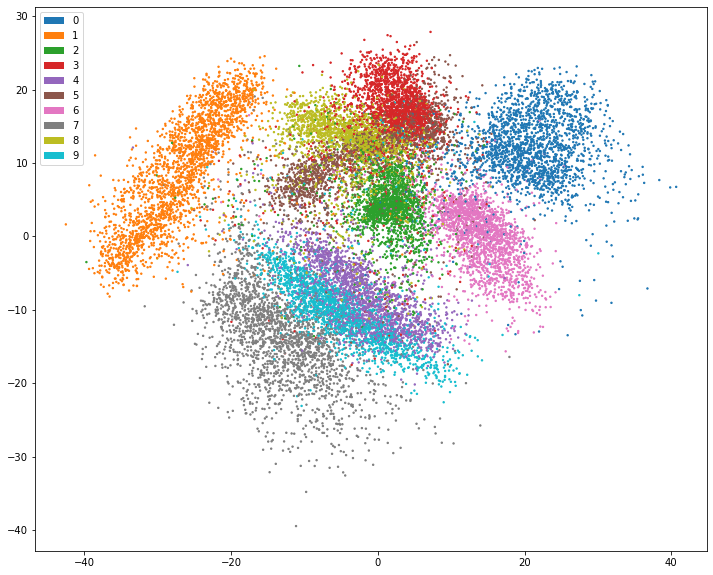

In [14]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in y_train[:20000]]
ax.scatter(bar[:,0],bar[:,1],c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)